In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

%matplotlib inline

In [2]:
# Importar polígonos de columnas
shapfile = 'MEX_adm//MEX_adm2.shp'

# Leer shapefile en geopandas
gdf = gpd.read_file(shapfile, encoding='utf-8')[['ID_1','NAME_1','ID_2','NAME_2', 'geometry']]

# Filtración para el estado de Colima
gdf = gdf[gdf['ID_1']==2]
gdf['MUNICIPIO'] = gdf['NAME_2'].apply(lambda x: x.lower())

# Visualización inicial de los datos
gdf.head()

ID_1               NAME_1  ID_2   NAME_2  \
9      2  Baja California Sur    10  Comondú   
10     2  Baja California Sur    11   La Paz   
11     2  Baja California Sur    12   Mulegé   

                                             geometry MUNICIPIO  
9   MULTIPOLYGON (((-112.13819 24.99653, -112.1381...   comondú  
10  MULTIPOLYGON (((-110.69625 25.20542, -110.6962...    la paz  
11  MULTIPOLYGON (((-114.16001 27.95285, -114.1599...    mulegé

In [3]:
# Lectura del archivo csv con la frecuencia de palabra por municipio
archivo_csv = pd.read_csv('baseDatosG/fosas.csv')
archivo_csv.head()

municipio  frecuencia
0           tecomán          23
1  villa de álvarez          11
2        guanajuato           2
3         villagrán          66
4              NONE          23

In [4]:
# Unión de ambos DataFrames
df_final = gdf.merge(archivo_csv, how = 'left', right_on = 'municipio', left_on = 'MUNICIPIO', suffixes = ("", "_2"))

#df_final.head()
print(df_final)

   ID_1               NAME_1  ID_2   NAME_2  \
0     2  Baja California Sur    10  Comondú   
1     2  Baja California Sur    11   La Paz   
2     2  Baja California Sur    12   Mulegé   

                                            geometry MUNICIPIO municipio  \
0  MULTIPOLYGON (((-112.13819 24.99653, -112.1381...   comondú       NaN   
1  MULTIPOLYGON (((-110.69625 25.20542, -110.6962...    la paz       NaN   
2  MULTIPOLYGON (((-114.16001 27.95285, -114.1599...    mulegé       NaN   

   frecuencia  
0         NaN  
1         NaN  
2         NaN  


In [5]:
# Renombramiento de columnas
df_final.rename(columns={'ID_1':'id_estado', 'NAME_1':'estado', 'ID_2':'id_municipio'}, inplace = True)

# DataFrame Final
df_final = df_final[['id_municipio', 'MUNICIPIO', 'frecuencia', 'geometry']]

#df_final['frecuencia'] = df_final['frecuencia'].map({'NaN': '0'})
df_final = df_final.fillna(0.1)
df_final.head()

id_municipio MUNICIPIO  frecuencia  \
0            10   comondú         0.1   
1            11    la paz         0.1   
2            12    mulegé         0.1   

                                            geometry  
0  MULTIPOLYGON (((-112.13819 24.99653, -112.1381...  
1  MULTIPOLYGON (((-110.69625 25.20542, -110.6962...  
2  MULTIPOLYGON (((-114.16001 27.95285, -114.1599...

<AxesSubplot:>

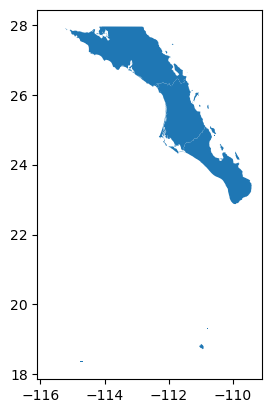

In [6]:
df_final.plot()

In [7]:
# Archivo json
archivo_json = json.loads(df_final.to_json())

# Conversión a string
json_data = json.dumps(archivo_json)

In [8]:
# Bokeh
from bokeh.io import output_notebook, show, output_file, save
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, HoverTool
from bokeh.palettes import brewer
import plotly as plt

# Max color
max_color = df_final['frecuencia'].max()

# Carga de los datos: json_data
gsource = GeoJSONDataSource(geojson = json_data)

# Paleta de colores
colores = brewer['YlGnBu'][9]

# Reversión para que el número mayor sea más oscuro
colores = colores[::-1]

# Asociar un número a los colores: azul más alto, amarillo más bajo
color_mapper = LinearColorMapper(palette = colores, low = 0, high = max_color)

# Agregación de hovers
hover = HoverTool(names = ['Municipios'], tooltips = [('Municipio', '@MUNICIPIO'), ('Frecuencia', '@frecuencia')])

# Creación del objeto figura
fig = figure(title = 'Frecuencia por municipio',
             plot_height = 600,
             plot_width = 950,
             toolbar_location = None,
             tools = [hover])

# Detalles del canvas
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
fig.title.text_font_size = '20pt'

fig.axis.visible = False

# Mapeo | Dibujo de los polígonos
fig.patches('xs', 'ys',
            source = gsource,
            fill_color = {'field': 'frecuencia', 'transform': color_mapper},
            line_color = 'black',
            line_width = 0.25,
            fill_alpha = 1,
            name = 'Municipios')

# Display
output_notebook()
show(fig)


Loading BokehJS ...

In [11]:
# Archivo HTML
output_file('Mapas/Mapa_fosas.html')
save(fig)

'C:\\Users\\drago\\Downloads\\SS\\proyecto\\Mapas\\Mapa_fosas.html'